In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import torch
import torch.optim as optim
import matplotlib.pyplot as plt

# Import all curve reparametrization functions
from deepshape.curves import *

# Set plotting Parameters
plt.rcParams["figure.figsize"] = (8, 6)
plt.rcParams["font.size"] = 16
plt.rcParams["xtick.labelsize"] = 16
plt.rcParams["ytick.labelsize"] = 16

In [3]:
# Analytic diffeomorphism
g = LogStepDiff()
g = lambda x: (0.5 * torch.log(20*x+1) / np.log(21.) 
                + 0.25 * (1 + torch.tanh(20*(x-0.5)) / np.tanh(21.)))

# Define Curves 
c1 = Infinity()  # See deepshape.curves.curves for definition.
c2 = c1.compose(g)

# Get Qmaps (reparametrize c1 into c2(x) = c1(g(x)))
# q, r = Qmap(c2), Qmap(c1)
q, r = SRVT(c2), SRVT(c1)

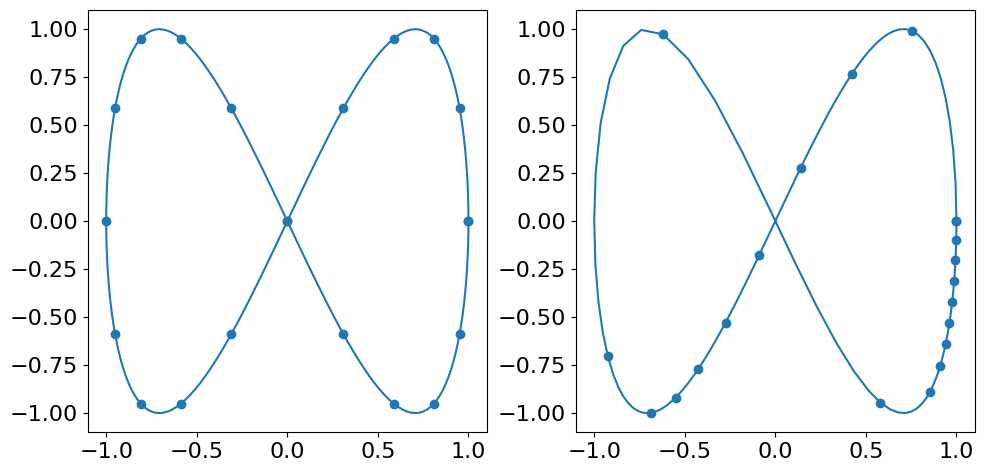

In [4]:
plt.figure(figsize=(10, 5))
plt.subplot(121)
plot_curve(c1, dotpoints=21, ax=plt.gca())
plt.subplot(122)
plot_curve(c2, dotpoints=21, ax=plt.gca())
plt.tight_layout()
plt.show()

[Iter     1] loss: 12.831166
[Iter     6] loss: 10.789042
[Iter    11] loss: 6.486057
[Iter    16] loss: 0.635923
[Iter    21] loss: 0.246084
[Iter    26] loss: 0.172732
[Iter    31] loss: 0.114091
[Iter    36] loss: 0.110514
[Iter    41] loss: 0.098703
[Iter    46] loss: 0.086960
[Iter    51] loss: 0.085823
[Iter    56] loss: 0.078130
[Iter    61] loss: 0.065348
[Iter    66] loss: 0.061887
[Iter    71] loss: 0.051217
[Iter    76] loss: 0.049725
[Iter    81] loss: 0.044176
[Iter    86] loss: 0.036594
[Iter    91] loss: 0.031033
[Iter    96] loss: 0.028086
[Iter   101] loss: 0.027124
[Iter   106] loss: 0.147528
[Iter   111] loss: 0.017480
[Iter   116] loss: 0.016056
[Iter   121] loss: 0.015363
[Iter   126] loss: 0.015064

Finished training in 0.63385s


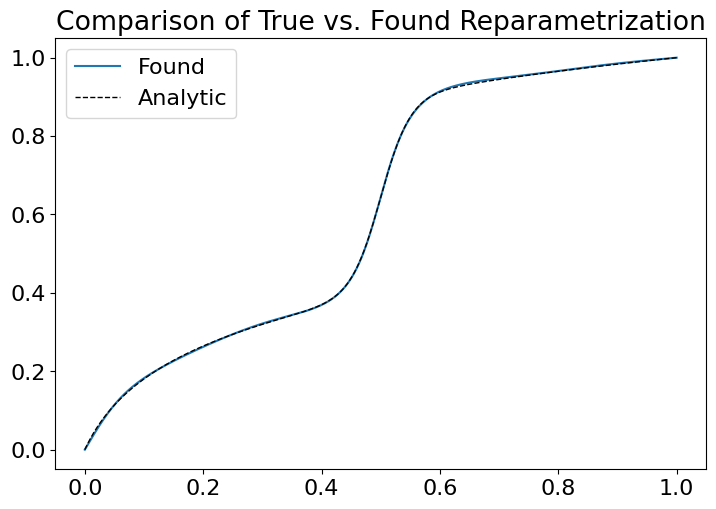

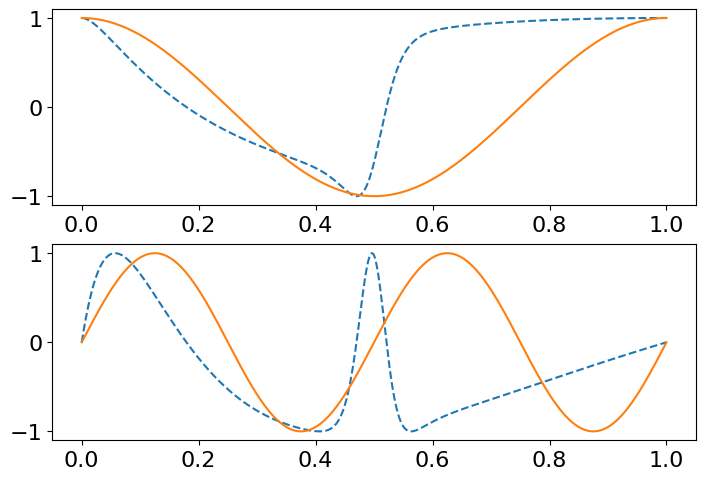

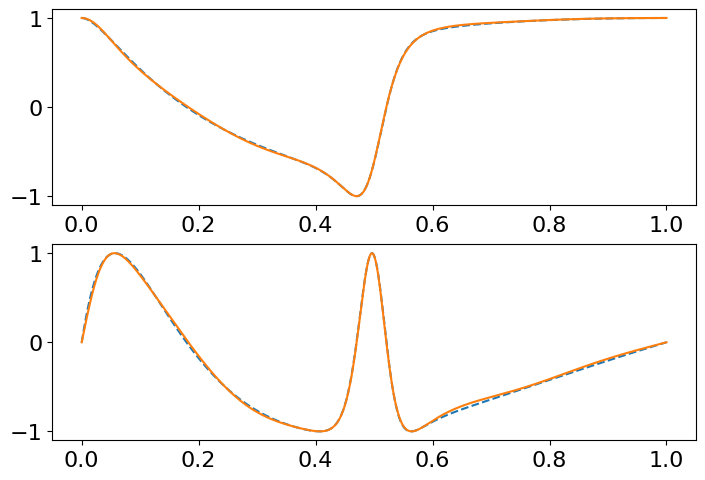

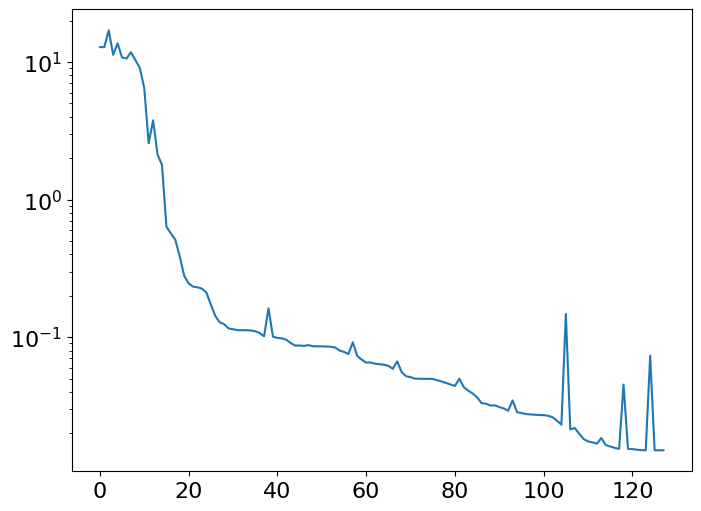

In [5]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Create reparametrization network
RN = ReparametrizationNetwork(nn.ModuleList([
    PalaisLayer(3) for _ in range(10)
]))

# Define loss function
loss_func = ShapeDistance(q, r, k=128)



# Choose and configure optimizer.
optimizer = optim.LBFGS(RN.parameters(), lr=1.0, max_iter=200, line_search_fn='strong_wolfe')
# optimizer = optim.SGD(RN.parameters(), lr=1e-3, momentum=0.5)

# Learning Rate Scheduler
scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode='min', factor=0.5, patience=2, threshold=0.,
    threshold_mode='rel', cooldown=10, min_lr=1e-6, eps=1e-08,
    verbose=True)

# q, r = q, 

# Train with BFGS-optimizer
error = reparametrize(q, r, RN, loss_func, optimizer, 100, Logger(5))#, scheduler=scheduler)

# RN.to("cpu")
# loss_func.to("cpu")

x, z, _, _, _ = get_plot_data(q, r, RN, 1024)

# Plot Diffeomorphism...
plt.figure(figsize=(8.4, 5.6))
plt.plot(x, z, label="Found", lw=1.5)
plt.plot(x, g(x), label="Analytic", ls="--", c="black", lw=1)
plt.title("Comparison of True vs. Found Reparametrization")
plt.legend()
plt.show()

# Get coordinates befora and after reparametrization
C1, C2, C3 = c1(x), c2(x), c1(z)

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8.3, 5.6))
ax1.plot(x, C2[:, 0], ls="dashed")
ax1.plot(x, C1[:, 0])

ax2.plot(x, C2[:, 1], ls="dashed")
ax2.plot(x, C1[:, 1])
plt.show()

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8.3, 5.6))
ax1.plot(x, C2[:, 0], ls="dashed")
ax1.plot(x, C3[:, 0])

ax2.plot(x, C2[:, 1], ls="dashed")
ax2.plot(x, C3[:, 1])
plt.show()

plt.figure()
plt.semilogy(error)
plt.show()

__Repeated using GPU (if available) for a large network takes more time, but allows very small errors.__

[Iter     1] loss: 12.876799
[Iter     6] loss: 6.940909
[Iter    11] loss: 6.127181
[Iter    16] loss: 0.349110
[Iter    21] loss: 0.024780
[Iter    26] loss: 0.003781
[Iter    31] loss: 0.000040
[Iter    36] loss: 0.000003
[Iter    41] loss: 0.000002
[Iter    46] loss: 0.000002
[Iter    51] loss: 0.000002
[Iter    56] loss: 0.000002
[Iter    61] loss: 0.000002
[Iter    61] loss: 0.000002

Finished training in 5.14604s


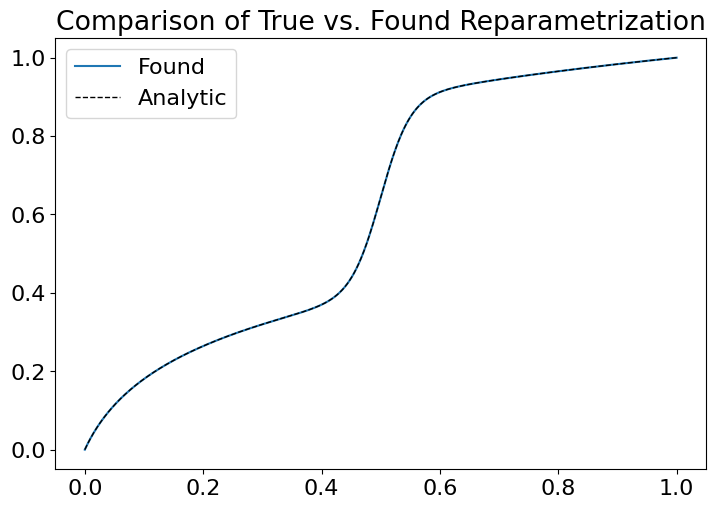

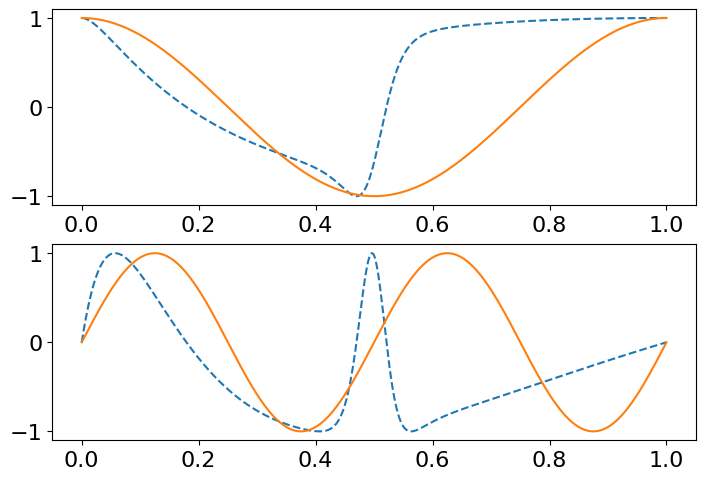

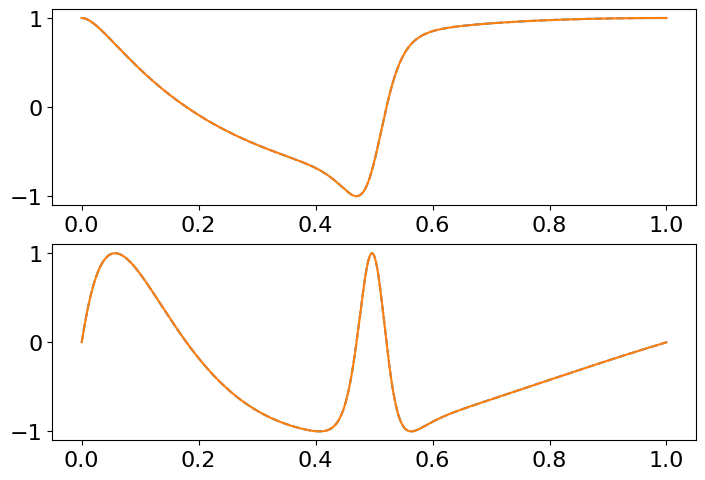

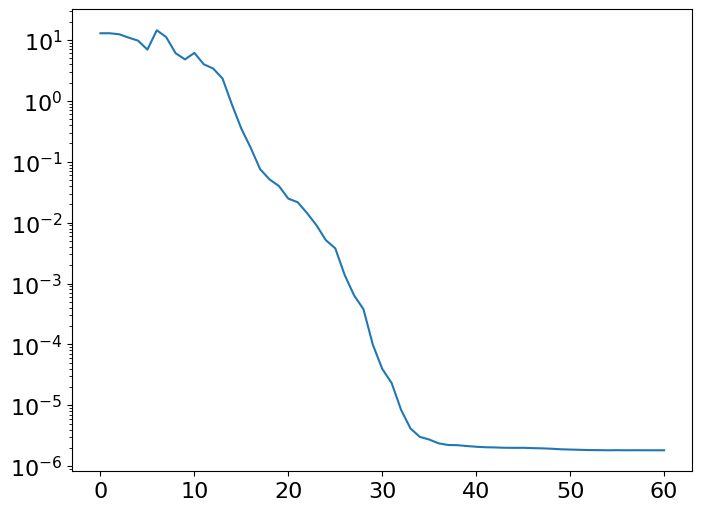

In [6]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Create reparametrization network
RN = ReparametrizationNetwork(nn.ModuleList([
    PalaisLayer(100) for _ in range(100)
])).to(device)

# Define loss function
loss_func = ShapeDistance(q, r, k=2048).to(device)


# Choose and configure optimizer.
optimizer = optim.LBFGS(RN.parameters(), lr=1.0, max_iter=200, line_search_fn='strong_wolfe')
# optimizer = optim.SGD(RN.parameters(), lr=1e-3, momentum=0.5)

# Learning Rate Scheduler
scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode='min', factor=0.5, patience=2, threshold=0.,
    threshold_mode='rel', cooldown=10, min_lr=1e-6, eps=1e-08,
    verbose=True)

# Train with BFGS-optimizer
error = reparametrize(q, r, RN, loss_func, optimizer, 100, Logger(5))#, scheduler=scheduler)

RN.to("cpu")
loss_func.to("cpu")



x, z, _, _, _ = get_plot_data(q, r, RN, 1024)

# Plot Diffeomorphism...
plt.figure(figsize=(8.4, 5.6))
plt.plot(x, z, label="Found", lw=1.5)
plt.plot(x, g(x), label="Analytic", ls="--", c="black", lw=1)
plt.title("Comparison of True vs. Found Reparametrization")
plt.legend()
plt.show()

# Get coordinates befora and after reparametrization
C1, C2, C3 = c1(x), c2(x), c1(z)

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8.3, 5.6))
ax1.plot(x, C2[:, 0], ls="dashed")
ax1.plot(x, C1[:, 0])

ax2.plot(x, C2[:, 1], ls="dashed")
ax2.plot(x, C1[:, 1])
plt.show()

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8.3, 5.6))
ax1.plot(x, C2[:, 0], ls="dashed")
ax1.plot(x, C3[:, 0])

ax2.plot(x, C2[:, 1], ls="dashed")
ax2.plot(x, C3[:, 1])
plt.show()

plt.figure()
plt.semilogy(error)
plt.show()